# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Импортируем библиотеки

In [1]:
# установим последнюю версию scikit-learn#
!pip install scikit-learn==1.1.3

In [2]:
#!pip install lightgbm

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

import re

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split,
    cross_val_score
)


from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)

import lightgbm as lgb

from catboost import CatBoostRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.metrics import (
    mean_squared_error,
    make_scorer
)

In [4]:
print("Версия LightGBM: ", lgb.__version__)

Версия LightGBM:  3.3.1


In [5]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.1.3.


In [6]:
# игнорирование предупреждений
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

In [7]:
# константа
RANDOM_STATE = 12345

### Загружаем и получаем информацию о датасете

**Считаем данные из csv-файлов в датафрейм и сохраним в переменные data.**

Данные находятся в файле:

- autos.csv 

Путь к файлу:

- /datasets/autos.csv

In [8]:
data = pd.read_csv('/datasets/autos.csv',parse_dates=True)

**Функция по выводу основной информации по датафреймам**

In [9]:
def all_info(data):

    
    print('\033[1m'+'1.Вывод первых 5 строк датафрейма'+'\033[0m')
    print('')
    display(data.head())
    print('')
    
    print('\033[1m'+'2.Выведим основную информацию о датафрейме.'+'\033[0m')
    print('')
    display(data.info())
    print('')
    
    print('Посмотрим на уникальные значения в столбцах базы данных.')
    print('')
    for i in data.columns:
        print('Кол-во уникальных значений в столбце', i, ':', data[i].nunique())
        print(pd.Series(data[i]).unique())
        print('')
    
    
    a = []
    b = []
    c = []
    count = 0
    for value in data.columns:
        a.append(data[value].isna().sum())
        b.append((data[value].isna().sum()/len(data))*100)
        c.append(value)
        count += 1

    f = pd.DataFrame( {'name_columns': pd.Series(c),
                       'count': pd.Series(a),
                      'count,%': pd.Series(b)}
                    )
    print('')
    print('\033[1m'+'3.Таблица пропусков по столбцам.'+'\033[0m')
    print('')
    display(f.sort_values(by=['count'], ascending=False))
    print('')
    print('Колв-во столбцов с пропусками:', len(f[f['count']>0]))
    print('')
    
    print('\033[1m'+'4.Кол-во уникальных дупликатов.'+'\033[0m')
    print('')
    print('Уникальных дупликатов:', data.duplicated().sum())
    print('')
    
    
    print('\033[1m'+'5.Выведим общую информацию о данных в столбцах.'+'\033[0m')
    print('')
    display(data.describe())
    print('')
    
    
    print('\033[1m'+'6.Построение общей гистограммы для всех числовых столбцов таблицы'+'\033[0m')
    print('')
    data.hist(bins = 100, figsize=(15, 10))
    plt.show()
    print('')

1.Вывод первых 5 строк датафрейма



,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



2.Выведим основную информацию о датафрейме.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354

None


Посмотрим на уникальные значения в столбцах базы данных.

Кол-во уникальных значений в столбце DateCrawled : 271174
['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']

Кол-во уникальных значений в столбце Price : 3731
[  480 18300  9800 ... 12395 18429 10985]

Кол-во уникальных значений в столбце VehicleType : 8
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

Кол-во уникальных значений в столбце RegistrationYear : 151
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 90

,name_columns,count,"count,%"
11,Repaired,71154,20.079070
2,VehicleType,37490,10.579368
9,FuelType,32895,9.282697
4,Gearbox,19833,5.596709
6,Model,19705,5.560588
0,DateCrawled,0,0.000000
1,Price,0,0.000000
3,RegistrationYear,0,0.000000
5,Power,0,0.000000
7,Kilometer,0,0.000000



Колв-во столбцов с пропусками: 5

4.Кол-во уникальных дупликатов.

Уникальных дупликатов: 4

5.Выведим общую информацию о данных в столбцах.



,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000



6.Построение общей гистограммы для всех числовых столбцов таблицы



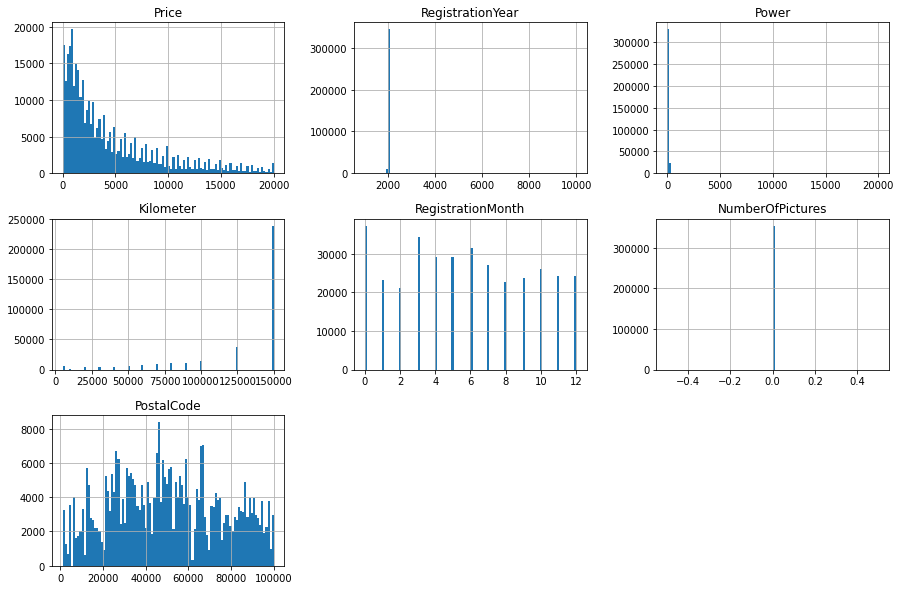

In [10]:
all_info(data)

**Описание данных**

**Признаки**
-	**DateCrawled** — дата скачивания анкеты из базы
-	**VehicleType** — тип автомобильного кузова
-	**RegistrationYear** — год регистрации автомобиля
-	**Gearbox** — тип коробки передач
-	**Power** — мощность (л. с.)
-	**Model** — модель автомобиля
-	**Kilometer** — пробег (км)
-	**RegistrationMonth** — месяц регистрации автомобиля
-	**FuelType** — тип топлива
-	**Brand** — марка автомобиля
-	**Repaired** — была машина в ремонте или нет
-	**DateCreated** — дата создания анкеты
-	**NumberOfPictures** — количество фотографий автомобиля
-	**PostalCode** — почтовый индекс владельца анкеты (пользователя)
-	**LastSeen** — дата последней активности пользователя

**Целевой признак**
- **Price** — цена (евро)


По выведеным данным можно сказать следующее:

- Строк: 354369. Столбцов: 16
- Кол-во столбцов с пропусками: 5. 
- Уникальные дупликатов 4
- столбцы записаны не в корректном виде.
- более 20% от всего датаферйма пропущенных значений в одном из столбце. Пропуски наблюдаются в столбцах Repaired, VehicleType, FuelType, Gearbox, Model. Небходимо будет их устранить.

- столбцы 'date_crawled', 'date_created','number_of_pictures','postal_code', 'last_seen' не несут полезной для информации для дальнейшего обучения модели. От них нужно будет избавиться. Также под сомнением бы поставил столбец 'registration_month', так как не особо уверен в том насколько сильно месяц регистрации автомобиля влияет на его цену. Куда важнее мне кажется год. Месяц был бы интересно, если бы на момент продажи автомобиля мы бы хотели знать сколько автомобилю уже полных лет и месяцев. И тогда мы бы еще исследовали с точки зрения длительности жизни автомобиля. Но если конечно модель уже при обучении не будет находить данную зависимость. Также в 'registration_month' наблюдается аномалия в виде числа 0 месяцев, что маловероятно. Это или опечатка или целенаправленное заоплнение пользователями. Но такого месяца не может быть и возможно таким образом пользователи зафиксировали, что не знают месяца регистрации. Или опечатались и имели ввиду 10 месяц, но покольку выбросов слишком много вероятно, что первый вариант. Другой вариант заменить нули на 'unknown' и сделать данный столбец категоральным. По итогу предлагается удалить столбец registration_month.
- Также наблюдаются аномалии по значениям в некоторых столбцах: 
- 1) RegistrationYear - странные значения по годам. Необходимо дополнительно исследовать.
- 2) Power - наблюдаются странные выбросы. а именно большое кол-во значений нуля и больших чисел за пределы 2000 (л. с.). Необходимо будет данный момент изучить. Есть вероятность, что пользователь при заполнение анкеты не знал данный параметр и не указал, тогда он выступает своего рода "индикатором" "unknown"
- 3) Price - большое кол-во машин по цене 0. Тоже надо будет изучить вопрос. Возможно пользователь также забыл указать или в редких случаях действительно отадвали за бесплатно, по разного рода причинам. Но учитывая, что это целевой признак и строки с знаечнием 0 составляет менее 10% от данных, то можно в некоторых случая посчитать, что в исходных данных присутсвует како-то незначительное значение неких ложно-положительных ответов. На фоне всех верных мони не должны сильно повлиять на обучение. Другой способ избавиться от нулей заменив их медианным значением цены в зависимости от бренда машины и года регистрации. 


In [11]:
all_rows_data = len(data)

### Устранение замечаний в датасете

**Приведем название встолбцов к корректному виду**

In [12]:
# перечнь столбоцв до перевода к корреткному виду
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [13]:
# перевод столбоцов к корреткному виду
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in data.columns]

In [14]:
# перечнь столбоцв после перевода к корреткному виду
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

**Избавимся от дупликатов**

In [15]:
data = data.drop_duplicates()

**Избавимся от неинформативных столбцов в признаках**

Избавимся от неинформативных столбцов в признаках, а именно: **'date_crawled', 'date_created','number_of_pictures','postal_code', 'last_seen','registration_month'**

In [16]:
data = data.drop(['date_crawled',
                  'date_created',
                  'number_of_pictures',
                  'postal_code', 
                  'last_seen',
                 'registration_month']
                 , axis=1)

In [17]:
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

**С помощью библиотеки seaborn построим тепловую карту для визуализации данных с пустыми ячейками.**

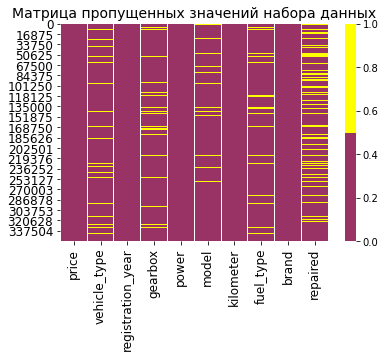

In [18]:
colours = ['#993366', '#FFFF00']
sns.heatmap(data.isnull(), cmap=sns.color_palette(colours))
# Decorations
plt.title('Матрица пропущенных значений набора данных', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Наблюдаются пропуски в нескольких столбцах одноврменно. Необходимо будет исследовать закономерность.

**Заполним значения в столбце "repaired"**

Устраним пустые значения в столбце **"repaired"**. Пустые значения земеним на значение 'no'. Вероятно, пользователь пропустил данный пункт при заполнение, так как машина не чинилась. Однако будем сразу заполнять не 'no', а на 0, а значения с 'yes' заменим на 1. Сделаем сразу прямое кодирование данных.

In [19]:
data['repaired'] = data['repaired'].fillna(0)

In [20]:
data.loc[data['repaired'] == 'no','repaired'] = 0

In [21]:
data.loc[data['repaired'] == 'yes','repaired'] = 1

In [22]:
data['repaired'] = data['repaired'].astype('int64')

**Заполним значения в столбце "model","vehicle_type", "gearbox", "fuel_type"**

Данные в рассматриваемых столбцах не возможно восстановить без дополнительных уточнений у заказачика. Можно данные пропуски заполнить как 'unknown' или 'other', так как последнее встречается в некоторых из рассматриваемых в столбцов и пользователь мог при заполнении пользователь пропустил данный пункт при заполнение. И в принципе можно считать, что  'unknown' и other' это одно и тоже, так как мы не знаем точно что имел ввиду пльзователь. Поэтому на данном моменте пока что заполним в рассматриваемых столбцах 'unknown', чтобы зафиксировать, где были пустые строки и это возможно понадобиться для исследовательского анализ. А уже в конце значения 'unknown' в столбцах  "model","vehicle_type", "fuel_type" заменим на 'other'. В "gearbox" тоже заменим пока что на 'unknown', но так как таких пропусков очень мало, то вероятно пользователь ошибся и имел ввиду 'manual' и затем вконце заменим на данной значение.

In [23]:
data['model'] = data['model'].fillna('unknown')

In [24]:
data['vehicle_type'] = data['vehicle_type'].fillna('unknown')

In [25]:
data['gearbox'] = data['gearbox'].fillna('unknown')

In [26]:
data['fuel_type'] = data['fuel_type'].fillna('unknown')

**Аномалии в данных**

**Столбец "registration_year"**

В столбце "registration_year" наблюдаются аномальные года. Посмотрим сколько таких строк. Рассмотрим, к примеру, вне периода с 1900 до 2023

In [27]:
len(data[(data['registration_year'] > 2023) | (data['registration_year'] < 1900)])

171

Строк мало. Удалим данные строки из датасета

In [28]:
data = data[(data['registration_year'] <= 2023) | (data['registration_year'] >= 1900)]

**Столбец "price"**

(-0.05, 15000.0)

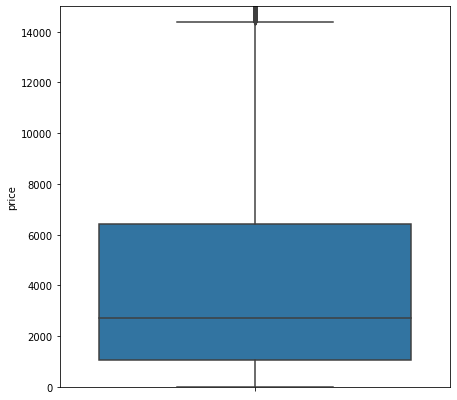

In [29]:
# построим диаграмму размаха
plt.figure(figsize=(7,7))
sns.boxplot(y = 'price', data = data);
#наблюдались выбросы до 20 000. Ограничили по оси Оу до 15_000 
plt.ylim(bottom=-0.05, top=15_000)

Наблюдается большое количесвто выбросов. Медианное значение смещено. Необходимо устранить лишние данны.

<AxesSubplot:>

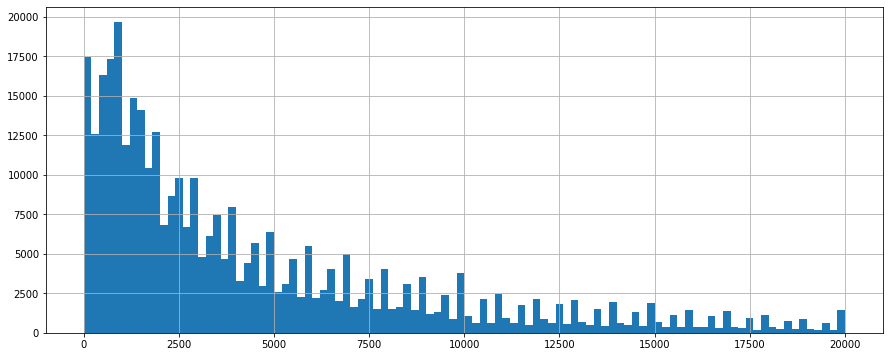

In [30]:
data['price'].hist(bins=100, figsize=(15,6))

<AxesSubplot:>

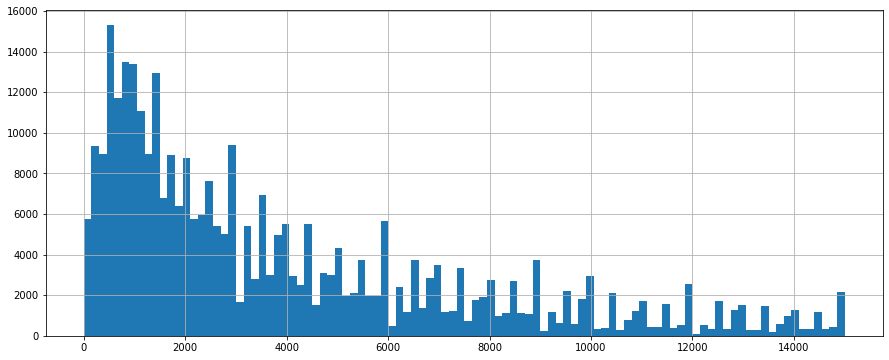

In [31]:
(
    data.loc[
        (data['price'] > 0) & 
        (data['price'] <= 15_000),'price'].hist(
        bins=100, 
        figsize=(15,6)
    )
)

Посмотриv на строки с ценой 0

In [32]:
data[data['price'] == 0].head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,0
40,0,unknown,1990,unknown,0,corsa,150000,petrol,opel,0
111,0,unknown,2017,manual,0,golf,5000,petrol,volkswagen,0
115,0,small,1999,unknown,0,unknown,5000,petrol,volkswagen,0
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,1
154,0,unknown,2006,unknown,0,other,5000,unknown,fiat,0
231,0,wagon,2001,manual,115,mondeo,150000,unknown,ford,0
334,0,unknown,2005,unknown,0,polo,150000,petrol,volkswagen,0
415,0,unknown,1985,unknown,0,3er,150000,unknown,bmw,0
466,0,unknown,2016,auto,197,3er,150000,gasoline,bmw,0


Посчитаем строки с ценой 0

In [33]:
print('Кол-во строк:',len(data[data['price'] == 0]))
print('Процент строк:',(len(data[data['price'] == 0])/len(data))*100, '%')

Кол-во строк: 10772
Процент строк: 3.0398035923412303 %


Данные с ценой в 0 занимают всего около 3%. Поэтому данные можно  удалить, оставить или сделать медианную замену. Предлагаю удалить.

In [34]:
print('Кол-во строк:',len(data[data['price'] > 15_000]))
print('Процент строк:',(len(data[data['price'] > 15_000])/len(data))*100, '%')

Кол-во строк: 14881
Процент строк: 4.19934248585498 %


Данных выше 15000 тоже около 4%. Предлагаю машины выше данной цены удалить из датасета

In [35]:
data = data[(data['price'] > 0) & (data['price'] <= 15_000)]

**Столбец "power"**

В столбце наблдаются аномалии по мощности автомобилей. Присутсвуют и машины с 0 и  12012 л.с. и далее.

(-0.05, 350.0)

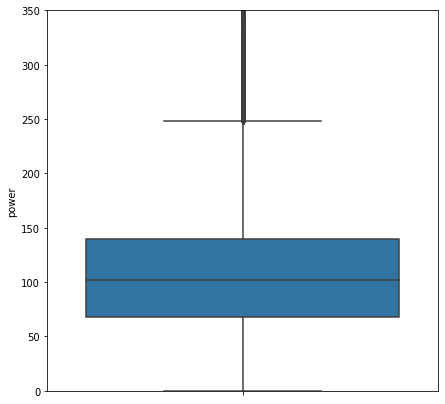

In [36]:
# построим диаграмму размаха
plt.figure(figsize=(7,7))
sns.boxplot(y = 'power', data = data);
#наблюдались выбросы до 20 000 л.с. Ограничили по оси Оу до 350 
plt.ylim(bottom=-0.05, top=350)

<AxesSubplot:>

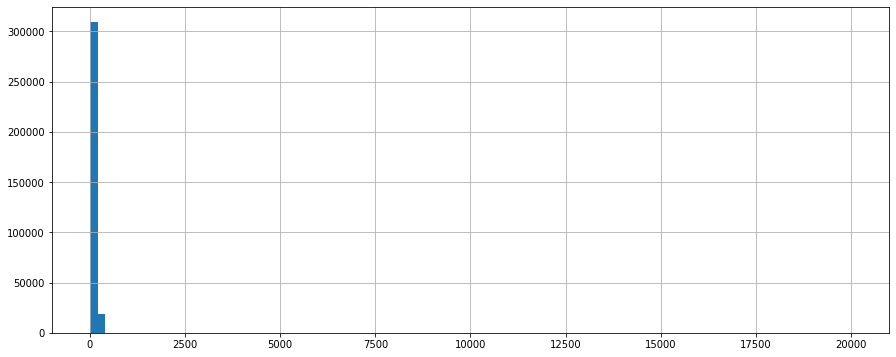

In [37]:
data['power'].hist(bins=100, figsize=(15,6))

<AxesSubplot:>

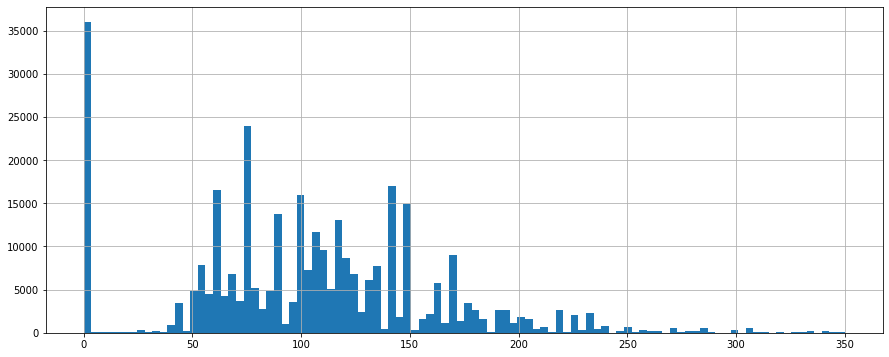

In [38]:
(
    data.loc[
        (data['power'] >= 0) & 
        (data['power'] <= 350),'power'].hist(
        bins=100, 
        figsize=(15,6)
    )
)

На самом деле машины могут быть и около 3000 л.с., но это уже специалные грузовые и я не до конца знаю продает ли данная компания такие машины. Выше данных показаний маловеротно, что машины есть и они здесь представлены. Да и выброс по ним большой и может повлиять на оценку.
У легковых же на данный момент максимальная мощность ориентировочно 1600 л.с.
Поэтому посчитаем сколько машин у нас имеют в датасете силу 0 и сколько которых выше пусть будет 350 л.с. и сделаем выводы.

Посчитаем строки с лошадиной силой 0

In [39]:
print('Кол-во строк:',len(data[data['power'] == 0]))
print('Процент строк:',(len(data[data['power'] == 0])/len(data))*100, '%')

Кол-во строк: 35924
Процент строк: 10.92871571466816 %


Посчитаем строки с лошадиной силой выше 600

In [40]:
print('Кол-во строк:',len(data[data['power'] > 350 ]))
print('Процент строк:',(len(data[data['power'] > 350 ])/len(data))*100, '%')

Кол-во строк: 808
Процент строк: 0.2458078804546229 %


строк с значением лощадиной силы 0 практически 11%, что достаточно много. Однако все ранво предлагается удалить, чтобы избавиться от аномальных выбросов. Диапазон оставим в пределах 15 л.с. и 350 л.с.

In [41]:
data = data[(data['power'] >= 15) & (data['power'] <= 350)]

In [42]:
print('Процент потерянных строк вего датасета строк:',100 - (len(data)/all_rows_data)*100, '%')

Процент потерянных строк вего датасета строк: 17.688624004921422 %


**Устраним строки в которых значения пользователем вероятно пропущены сразу в нескольких столбцах**

Данные значения нам не особо полезны, так неизвестных данных в них наблюдается много

In [43]:
a = (
    len(data[(data['fuel_type'] == 'unknown') &
             (data['model'] == 'unknown') & 
             (data['gearbox'] == 'unknown') & 
             (data['vehicle_type'] == 'unknown')
            ]
       )
)

print('Кол-во строк:',a)
print('Процент строк:',(a/len(data))*100, '%')

Кол-во строк: 198
Процент строк: 0.06788121473090926 %


In [44]:
len(data)

291686

Удалим строки

In [45]:
data = (
    data[(data['fuel_type'] != 'unknown') |
         (data['model'] != 'unknown') | 
         (data['gearbox'] != 'unknown') | 
         (data['vehicle_type'] != 'unknown')
        ]
)

In [46]:
len(data)

291488

In [47]:
print('Процент потерянных строк всего датасета  по итогу обработки данных:',
      100 - (len(data)/all_rows_data)*100, '%')

Процент потерянных строк всего датасета  по итогу обработки данных: 17.74449796680861 %


Выполним замену в столбцах "model","vehicle_type", "fuel_type" c 'unknown' на 'other'

In [48]:
data.loc[data['model'] == 'unknown','model'] = 'other'
data.loc[data['vehicle_type'] == 'unknown','vehicle_type'] = 'other'
data.loc[data['fuel_type'] == 'unknown','fuel_type'] = 'other'

Выполним замену в столбц "gearbox" c 'unknown' на 'manual'

In [49]:
data.loc[data['gearbox'] == 'unknown','gearbox'] = 'manual'

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291488 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              291488 non-null  int64 
 1   vehicle_type       291488 non-null  object
 2   registration_year  291488 non-null  int64 
 3   gearbox            291488 non-null  object
 4   power              291488 non-null  int64 
 5   model              291488 non-null  object
 6   kilometer          291488 non-null  int64 
 7   fuel_type          291488 non-null  object
 8   brand              291488 non-null  object
 9   repaired           291488 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 24.5+ MB


### Вывод по пункту




В данном шаге была выполнена подготовка данных к исследованиям.
В ходы подготовки было сделано:
1. перевод названий столбцов к нижнему регистру
2. посчитано кол-во пропущенных строк и их процент от всех строк 

| Наименование столбца  | Кол-во пустых строк | Процент пустых строк |
| :---               | :----             | :---    |
| Repaired         | 71154              | 20.079070 |
| VehicleType       | 37490              | 10.579368 |
| FuelType             | 32895              | 9.282697 |
| Gearbox    | 19833               | 5.596709 |
| Model               | 19705                 | 5.560588 |

3. пустые значения в столбцах выше было принято решение заменить в Repaired на 0, 'yes' заменили на 1. В 'Gearbox' на 'manual'. в остальных на 'other'. Пропуски наблюдались только в категорийных признаках.
4. Избавились от 4 уникальных дупликатов.
5. Избавились от неинформативных столбцов в признаках, а именно: 'date_crawled', 'date_created','number_of_pictures','postal_code', 'last_seen', 'registration_month'
6. Данные очистили от выбросов в 'power', 'price'.
7. Также удалил строки в которых пропущенные значения наблюдались сразу в нескольких столбцах

 
Процент потерянных строк всего датасета  по итогу обработки данных: 17.74449796680861 %
Стало 
- Строк: 291488
- Столбцов: 10

## Обучение моделей

 В рамках данного задания обучим модели градиентного бустинга LightGBM и Catboost, а также  модель Линейная регрессия и Ridge 

### Разбиение данных

Разделим датасет на тренировочную и тестовую выборки

In [51]:
features = data.drop(['price'], axis=1)
target = data['price']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)

### Масштабирование данных

In [52]:
numeric = X_train.select_dtypes(exclude='object').columns.to_list()
print(numeric)

['registration_year', 'power', 'kilometer', 'repaired']


In [53]:
scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

In [54]:
X_train.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
126578,other,0.456565,manual,-0.095822,rio,0.560571,petrol,kia,-0.335045
164585,small,0.028541,manual,-1.104482,getz,-0.151677,petrol,hyundai,2.984672
352112,small,-0.256808,manual,-0.842230,golf,0.560571,petrol,volkswagen,-0.335045
165970,small,-0.328145,manual,-1.427254,polo,0.560571,petrol,volkswagen,-0.335045
31176,wagon,-0.078464,manual,0.771626,a6,0.560571,gasoline,audi,-0.335045


In [55]:
X_test.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
154649,wagon,-0.221139,manual,-0.015129,vectra,0.560571,petrol,opel,-0.335045
185738,sedan,-0.256808,manual,-0.539632,golf,-0.151677,petrol,volkswagen,-0.335045
325359,small,0.206885,manual,-0.539632,corsa,0.560571,petrol,opel,-0.335045
159749,sedan,-0.078464,manual,-0.539632,almera,-0.151677,petrol,nissan,-0.335045
271432,sedan,0.135547,auto,2.889814,a8,-0.151677,petrol,audi,-0.335045


### Кодирование данных (OHE)

Преобразовывание категориальных признаков в численные с техникой прямого кодирования, или отображения (англ. One-Hot Encoding, OHE). Данные необходимо кодировать для линейной регрессии и Ridge .  Для CatBoost, LightGBM нет необходимости делать кодирование, так как данный этап встроен в библиотеку.

In [56]:
X_train_ohe = X_train.copy()
X_test_ohe = X_test.copy()

In [57]:
#категориальные признаки для OHE 
ohe_features_columns = X_train_ohe.select_dtypes(include='object').columns.to_list()
print(ohe_features_columns)

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand']


In [58]:
# признак repaired уже бинарный, его не будем кодировать/масштабировать
# добавляем remainder='passthrough, чтобы он не пропал 
col_transformer_ohe = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        ohe_features_columns
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

# всё готово в пару строк кода
X_train_ohe = pd.DataFrame.sparse.from_spmatrix(
    col_transformer_ohe.fit_transform(X_train_ohe),
    columns=col_transformer_ohe.get_feature_names_out()
)

# смотрим на результат
X_train_ohe.head()

,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_601,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_citigo,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_doblo,model_ducato,model_duster,model_e_klasse,model_elefantino,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i3,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalina,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_other,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_evoque,model_range_rover_sport,model_rangerover,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_serie_2,model_serie_3,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_trail,model_x_type,model_xc_reihe,model_yaris,model_yeti,model_ypsilon,model_z_reihe,model_zafira,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,registration_year,power,kilometer,repaired
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [59]:
# трансформируем тестовую выборку
X_test_ohe = pd.DataFrame.sparse.from_spmatrix(
    col_transformer_ohe.transform(X_test_ohe),
    columns=col_transformer_ohe.get_feature_names_out()
)

# смотрим на результат
X_test_ohe.head()

,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_601,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_citigo,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_doblo,model_ducato,model_duster,model_e_klasse,model_elefantino,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i3,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalina,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_other,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_evoque,model_range_rover_sport,model_rangerover,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_serie_2,model_serie_3,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_trail,model_x_type,model_xc_reihe,model_yaris,model_yeti,model_ypsilon,model_z_reihe,model_zafira,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,registration_year,power,kilometer,repaired
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [60]:
# X_test_ohe.shape

### Ridge

In [61]:
%%time
model_ridge = Ridge(random_state=RANDOM_STATE)

CPU times: user 21 µs, sys: 3 µs, total: 24 µs
Wall time: 27.2 µs


In [62]:
%%time
# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_ridge = {
    'alpha': np.arange(0, 0.2, 0.01),
}

gs_ridge = GridSearchCV(
    model_ridge, 
    param_grid=param_grid_ridge, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

CPU times: user 121 µs, sys: 0 ns, total: 121 µs
Wall time: 108 µs


In [63]:
%%time
gs_ridge.fit(X_train_ohe, y_train)

CPU times: user 6min 40s, sys: 4min 14s, total: 10min 55s
Wall time: 10min 57s


GridSearchCV(estimator=Ridge(random_state=12345), n_jobs=-1,
             param_grid={'alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19])},
             scoring='neg_root_mean_squared_error')

In [64]:
# лучшее значение RMSE 
print(f'best_score: {gs_ridge.best_score_ * -1}')

# лучшие гиперпараметры
print(f'best_params: {gs_ridge.best_params_}')

best_score: 2403.6229955533368
best_params: {'alpha': 0.15}


### LinearRegression()

In [65]:
%%time
model_linear = LinearRegression()

CPU times: user 9 µs, sys: 6 µs, total: 15 µs
Wall time: 18.1 µs


In [66]:
%%time
model_linear.fit(X_train_ohe, y_train)

CPU times: user 19 s, sys: 24 s, total: 43 s
Wall time: 43.5 s


LinearRegression()

In [67]:
%%time
scores = cross_val_score(
    model_linear, 
    X_train_ohe, 
    y_train, 
    cv=5, 
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)
                        
linear_score = abs(scores.mean())**.5

CPU times: user 1min 39s, sys: 1min 55s, total: 3min 35s
Wall time: 3min 36s


In [68]:
print(linear_score)

2402.4826401414266


### LightGBM

Прежде, чем применить данные необходиом изменить у признаков на тренировочной и тествой выборке тип данных у стобцов категориальных с 'object' на тип 'category'

In [69]:
for i in ohe_features_columns:
    X_train[i] = X_train[i].astype('category')
    X_test[i] = X_test[i].astype('category')

In [70]:
%%time
model_gbm = lgb.LGBMRegressor()

CPU times: user 19 µs, sys: 14 µs, total: 33 µs
Wall time: 36 µs


In [71]:
param_grid_gbm = {
    'num_leaves':[30,50], 
    'learning_rate':[0.2,0.5],
    'random_state':[RANDOM_STATE]
                 }

In [72]:
%%time
gs_gbm = GridSearchCV(
    model_gbm,
    param_grid=param_grid_gbm,
    scoring='neg_root_mean_squared_error')

CPU times: user 14 µs, sys: 11 µs, total: 25 µs
Wall time: 28.8 µs


In [73]:
%%time
gs_gbm.fit(X_train, y_train,categorical_feature=ohe_features_columns)

CPU times: user 18min 26s, sys: 1.76 s, total: 18min 27s
Wall time: 18min 36s


GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.2, 0.5], 'num_leaves': [30, 50],
                         'random_state': [12345]},
             scoring='neg_root_mean_squared_error')

In [74]:
# лучшее значение RMSE 
print(f'best_score: {gs_gbm.best_score_ * -1}')

# лучшие гиперпараметры
print(f'best_params: {gs_gbm.best_params_}')

best_score: 1388.800349870237
best_params: {'learning_rate': 0.2, 'num_leaves': 50, 'random_state': 12345}


### CatBoost

In [75]:
%%time
model_catboost = CatBoostRegressor(
    verbose=False,
    loss_function='RMSE',
    cat_features=ohe_features_columns)

CPU times: user 79 µs, sys: 19 µs, total: 98 µs
Wall time: 102 µs


In [76]:
param_grid_catboost = {
    'depth'         : [6,8],
    'learning_rate' : [0.01,0.02],
    'iterations'    : [20,50],
    'random_state'  : [RANDOM_STATE]
}

In [77]:
%%time
gs_catboost = GridSearchCV(
    model_catboost,
    param_grid=param_grid_catboost,
    scoring='neg_root_mean_squared_error')

CPU times: user 23 µs, sys: 0 ns, total: 23 µs
Wall time: 27.4 µs


In [78]:
%%time
gs_catboost.fit(X_train, y_train)

CPU times: user 1min 49s, sys: 1.98 s, total: 1min 51s
Wall time: 2min 42s


GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x7fa2f008cac0>,
             param_grid={'depth': [6, 8], 'iterations': [20, 50],
                         'learning_rate': [0.01, 0.02],
                         'random_state': [12345]},
             scoring='neg_root_mean_squared_error')

In [79]:
# лучшее значение RMSE 
print(f'best_score: {gs_catboost.best_score_ * -1}')

# лучшие гиперпараметры
print(f'best_params: {gs_catboost.best_params_}')

best_score: 2269.438583528923
best_params: {'depth': 8, 'iterations': 50, 'learning_rate': 0.02, 'random_state': 12345}


### Вывод по пункту

В данном пункте были рассмотрены 4 модели машинного обучения:
1. Ridge
2. LinearRegression
3. LightGBM
4. CatBoost

Данные были предварительно разделены на тренировочную и тестовую выборку в соотношение 75:25.
Проведено масштабирование данных.
Также проведено кодирование данных тренировочной и тестовой выборки методом OHE для обучения моделей Ridge и LinearRegression.
Для обучения моделей LightGBM и CatBoost данные брали без кодирования.

В итоге для каждой модели были подобраны гиперпараметры, которые выдают RMSE меньше 2500.

Итого:

| Модель    |   Лучшие гиперпараметры | Лучшее RMSE | Время обучения и поиска гиперпараметров| 
| :---      | :----                   | :----      | :----                  | 
|  Ridge        |     alpha=0.15           |2403.62           |10min 57s              |
|LinearRegression | cv=5              |2402.4826           |4min               |
|  LightGBM        |  learning_rate=0.2, num_leaves=50,         |1388.8  |18min 36s              |
|   CatBoost    |     depth=8, iterations=50, learning_rate=0.02          |2269.4386       |2min 42s               |


Лучшие рещультаты по RMSE у LightGBM, а лучшее время по вычислению CatBoost. 
Посмотрим Как модели вычисляются с лучшими гиперпараметрами.

## Анализ моделей

В предыдущем пункте нашли гиперпараметры моделй, которые дают RMSE меньше 2500. Обучим модели на данных параметрах и посомтрим сколько времени занимает их обучение и предсказание

### Ridge

In [80]:
%%time
model_ridge_1 = Ridge(
    alpha=0.15,
    random_state=RANDOM_STATE
)

CPU times: user 17 µs, sys: 4 µs, total: 21 µs
Wall time: 25 µs


In [81]:
%%time
model_ridge_1.fit(X_train_ohe, y_train)

CPU times: user 2.84 s, sys: 3.01 s, total: 5.86 s
Wall time: 5.83 s


Ridge(alpha=0.15, random_state=12345)

In [82]:
%%time
predictions_1 = model_ridge_1.predict(X_train_ohe)

CPU times: user 38.9 ms, sys: 4.89 ms, total: 43.8 ms
Wall time: 41.3 ms


In [83]:
%%time
score_ridge = mean_squared_error(y_train,predictions_1)**.5
print(f'score: {score_ridge}')

score: 2397.0814443920817
CPU times: user 3.92 ms, sys: 84 µs, total: 4 ms
Wall time: 2.43 ms


### LinearRegression()

Модель была обучена ранее. 

### LightGBM

In [84]:
%%time
model_gbm_1 = lgb.LGBMRegressor(
    num_leaves=50,
    learning_rate=0.2,
    random_state=RANDOM_STATE
)

CPU times: user 24 µs, sys: 6 µs, total: 30 µs
Wall time: 33.4 µs


In [85]:
%%time
model_gbm_1.fit(X_train, y_train,categorical_feature=ohe_features_columns)

CPU times: user 11min 39s, sys: 4.58 s, total: 11min 43s
Wall time: 11min 49s


LGBMRegressor(learning_rate=0.2, num_leaves=50, random_state=12345)

In [86]:
%%time
predictions_3 = model_gbm_1.predict(X_train)

CPU times: user 2.1 s, sys: 0 ns, total: 2.1 s
Wall time: 2.12 s


In [87]:
%%time
score_gbm = mean_squared_error(y_train,predictions_3)**.5
print(f'score: {score_gbm}')

score: 1303.3399055912273
CPU times: user 4.5 ms, sys: 0 ns, total: 4.5 ms
Wall time: 2.67 ms


### CatBoost

In [88]:
model_catboost_1 = CatBoostRegressor(
    verbose=False,
    loss_function='RMSE',
    cat_features=ohe_features_columns,
    depth=8,
    learning_rate=0.02,
    iterations=50,
    random_state=RANDOM_STATE)

In [89]:
%%time
model_catboost_1.fit(X_train, y_train)

CPU times: user 4.73 s, sys: 84.2 ms, total: 4.81 s
Wall time: 5.75 s


In [90]:
%%time
predictions_4 = model_catboost_1.predict(X_train)

CPU times: user 184 ms, sys: 5.45 ms, total: 190 ms
Wall time: 187 ms


In [91]:
%%time
score_catboost = mean_squared_error(y_train,predictions_4)**.5
print(f'score: {score_catboost}')

score: 2261.0130857853565
CPU times: user 4.23 ms, sys: 84 µs, total: 4.32 ms
Wall time: 2.81 ms


### Лучшая модель

Итого результаты с заданными гиперпараметрами:

| Модель           |   RMSE                      |  Лучшие гиперпараметры | Время обучения | Время предсказания | 
| :---             | :----                      | :----                    | :----          | :----              | 
| Ridge            |  2403.62                   | alpha=0.15                |5.83 s          |41.3 ms|
| LinearRegression |  2402.4826                 | cv=5               |	43.5 s          |3min 36s |
| LightGBM         |  1388.8                     |learning_rate=0.2, num_leaves=50        |11min 49s  |2.12 s|
| CatBoost         |  2269.4386                 |depth=8, iterations=50, learning_rate=0.02 |5.75 s         |187 ms|


Лучшие результаты по RMSE у модели LightGBM, однако моедль обучается 11 мин, что очень долго по сравнению с другими.
Следующая модель у которой минимальная RMSE и малое время исполнения и обучения и предсказания у CatBoost. Да время обучение предсказания и обучения чуть короче у Ridge, но RMSE больше. Думаю клиенту в данному случае разнича в 100ms критичной не будет, а вот показатель в RMSE будет выйгрышней. Поэтому выберем ммодель CatBoost


Проверим модель CatBoost на тестовой выборке

In [92]:
%%time
predictions_5 = model_catboost_1.predict(X_test)

CPU times: user 43.3 ms, sys: 4.05 ms, total: 47.3 ms
Wall time: 44.9 ms


In [93]:
%%time
score_catboost_test = mean_squared_error(y_test,predictions_5)**.5
print(f'score: {score_catboost_test}')

score: 2256.9265954403595
CPU times: user 3.03 ms, sys: 503 µs, total: 3.53 ms
Wall time: 1.9 ms


### Вывод по пункту

В итоге для каждой модели были подобраны гиперпараметры, которые выдают RMSE меньше 2500.

Итого результаты с заданными гиперпараметрами:


| Модель           |   RMSE                      |  Лучшие гиперпараметры | Время обучения | Время предсказания | 
| :---             | :----                      | :----                    | :----          | :----              | 
| Ridge            |  2403.62                   | alpha=0.15                |5.83 s          |41.3 ms|
| LinearRegression |  2402.4826                 | cv=5               |	43.5 s          |3min 36s |
| LightGBM         |  1388.8                     |learning_rate=0.2, num_leaves=50        |11min 49s  |2.12 s|
| CatBoost         |  2269.4386                 |depth=8, iterations=50, learning_rate=0.02 |5.75 s         |187 ms|


Лучшие результаты по RMSE у модели LightGBM, однако моедль обучается 11 мин, что очень долго по сравнению с другими.
Следующая модель у которой минимальная RMSE и малое время исполнения и обучения и предсказания у CatBoost. Да время обучение предсказания и обучения чуть короче у Ridge, но RMSE больше. Думаю клиенту в данному случае разнича в 100ms критичной не будет, а вот показатель в RMSE будет выйгрышней. Поэтому выберем ммодель CatBoost
На тестовой выборке результаты :
- RMSE 2256.9265
- время обучения:5.75 s 
- время предсказания: 44.9 ms

## Итог

По заданию необходимо построить модель для определения стоимости автомобиля для сервиса по продаже автомобилей с пробегом. Компания разрабатывает приложение для привлечения новых клиентов в котором можно быстро узнать рыночную стоимость своего автомобиля. 

В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

Заказчику важны построение модели:

- качество предсказания;
- скорость предсказания;
- время обучения.

Для выполнения данного проекта были выполнены следущие шаги:

- ШАГ 1

В данном шаге была выполнена подготовка данных к исследованиям.
В ходы подготовки было сделано:
1. перевод названий столбцов к нижнему регистру
2. посчитано кол-во пропущенных строк и их процент от всех строк 

| Наименование столбца  | Кол-во пустых строк | Процент пустых строк |
| :---               | :----             | :---    |
| Repaired         | 71154              | 20.079070 |
| VehicleType       | 37490              | 10.579368 |
| FuelType             | 32895              | 9.282697 |
| Gearbox    | 19833               | 5.596709 |
| Model               | 19705                 | 5.560588 |

3. пустые значения в столбцах выше было принято решение заменить в Repaired на 0, 'yes' заменили на 1. В 'Gearbox' на 'manual'. в остальных на 'other'. Пропуски наблюдались только в категорийных признаках.
4. Избавились от 4 уникальных дупликатов.
5. Избавились от неинформативных столбцов в признаках, а именно: 'date_crawled', 'date_created','number_of_pictures','postal_code', 'last_seen', 'registration_month'
6. Данные очистили от выбросов в 'power', 'price'.
7. Также удалил строки в которых пропущенные значения наблюдались сразу в нескольких столбцах

 
Процент потерянных строк всего датасета  по итогу обработки данных: 17.74449796680861 %

Было:

- Строк: 354369
- Столбцов: 16

Стало 
- Строк: 291488
- Столбцов: 10




- ШАГ 2

В данном пункте были рассмотрены 4 модели машинного обучения:
1. Ridge
2. LinearRegression
3. LightGBM
4. CatBoost

Данные были предварительно разделены на тренировочную и тестовую выборку в соотношение 75:25.
Проведено масштабирование данных.
Также проведено кодирование данных тренировочной и тестовой выборки методом OHE для обучения моделей Ridge и LinearRegression.
Для обучения моделей LightGBM и CatBoost данные брали без кодирования.

В итоге для каждой модели были подобраны гиперпараметры, которые выдают RMSE меньше 2500.

Итого:

| Модель    |   Лучшие гиперпараметры | Лучшее RMSE | Время обучения и поиска гиперпараметров| 
| :---      | :----                   | :----      | :----                  | 
|  Ridge        |     alpha=0.15           |2403.62           |10min 57s              |
|LinearRegression | cv=5              |2402.4826           |4min               |
|  LightGBM        |  learning_rate=0.2, num_leaves=50,         |1388.8  |18min 36s              |
|   CatBoost    |     depth=8, iterations=50, learning_rate=0.02          |2269.4386       |2min 42s               |


Лучшие рещультаты по RMSE у LightGBM, а лучшее время по вычислению CatBoost. 


- ШАГ 3

В итоге для каждой модели были подобраны гиперпараметры, которые выдают RMSE меньше 2500.

Итого результаты с заданными гиперпараметрами:

| Модель           |   RMSE                      |  Лучшие гиперпараметры | Время обучения | Время предсказания | 
| :---             | :----                      | :----                    | :----          | :----              | 
| Ridge            |  2403.62                   | alpha=0.15                |5.83 s          |41.3 ms|
| LinearRegression |  2402.4826                 | cv=5               |	43.5 s          |3min 36s |
| LightGBM         |  1388.8                     |learning_rate=0.2, num_leaves=50        |11min 49s  |2.12 s|
| CatBoost         |  2269.4386                 |depth=8, iterations=50, learning_rate=0.02 |5.75 s         |187 ms|


Лучшие результаты по RMSE у модели LightGBM, однако моедль обучается 11 мин, что очень долго по сравнению с другими.
Следующая модель у которой минимальная RMSE и малое время исполнения и обучения и предсказания у CatBoost. Да время обучение предсказания и обучения чуть короче у Ridge, но RMSE больше. Думаю клиенту в данному случае разнича в 100ms критичной не будет, а вот показатель в RMSE будет выйгрышней. Поэтому выберем ммодель CatBoost

На тестовой выборке результаты :
- RMSE 2256.9265
- время обучения:5.75 s 
- время предсказания: 44.9 ms